In [1]:
import tensorflow as tf
import pandas as pd
import seaborn as sns

from tensorflow.keras import datasets, layers, models
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D , Flatten , BatchNormalization , Lambda , Activation , Dropout
from keras import backend as K

import matplotlib.pyplot as plt

In [2]:
TARGET_X = 256
TARGET_Y = 256
BATCH_SIZE = 32
CLASS_NUM = 1103
EPOCH = 15


In [3]:
def append_ext(fn):
    return fn+".png"

train_classes=pd.read_csv('./multilabel_small.csv', dtype=str)
#Changing the attribute ids into lists instead of str seperated by a ' ' to be able to count them
train_classes['attribute_ids']=train_classes['attribute_ids'].apply(lambda x:x.split(" "))
train_classes["id"]=train_classes["id"].apply(lambda x:x+".png")

print('train : \n', train_classes.head())

train : 
                      id attribute_ids
0  1007057734dba6df.png         [189]
1   1009f5737fc77f2.png         [188]
2  100a58282c6584bf.png         [147]
3  100b45b7c4020f5d.png         [161]
4  101695e8cefdc9c4.png          [13]


In [4]:
labels = list(map(str, range(CLASS_NUM)))

In [5]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255.,
                             validation_split=0.2,
                             horizontal_flip = True,    
                             zoom_range = 0.3,
                             width_shift_range = 0.3,
                             height_shift_range=0.3)

train_gen = datagen.flow_from_dataframe(dataframe= train_classes,
                                             directory='../data',
                                             x_col="id",
                                             y_col="attribute_ids",
                                             subset="training",
                                             target_size = (TARGET_X,TARGET_Y),
                                             batch_size=BATCH_SIZE,
                                             classes=labels,
                                             class_name='categorical')

valid_gen = datagen.flow_from_dataframe(dataframe= train_classes,
                                             directory='../data',
                                             x_col="id",
                                             y_col="attribute_ids",
                                             subset="validation",
                                             target_size = (TARGET_X,TARGET_Y),
                                             batch_size=BATCH_SIZE,
                                             classes=labels,
                                             class_name='categorical')

Found 9546 validated image filenames belonging to 1103 classes.
Found 2386 validated image filenames belonging to 1103 classes.


In [6]:
model = Sequential()

model.add(Conv2D(96, 7, strides=3, padding='same', input_shape=(TARGET_X,TARGET_Y,3)))
model.add(Lambda(tf.nn.local_response_normalization))
model.add(Activation('relu'))
model.add(MaxPooling2D(3, strides=2))
model.add(Conv2D(256, 5, strides=3, padding='same'))
model.add(Lambda(tf.nn.local_response_normalization))
model.add(Activation('relu'))
model.add(MaxPooling2D(3, strides=2))
model.add(Dropout(0.5))
model.add(Conv2D(384, 3, strides=4, padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(384, 3, strides=4, padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(256, 3, strides=4, padding='same'))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4096, activation='relu'))
model.add(Dense(CLASS_NUM, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 86, 86, 96)        14208     
_________________________________________________________________
lambda (Lambda)              (None, 86, 86, 96)        0         
_________________________________________________________________
activation (Activation)      (None, 86, 86, 96)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 42, 42, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 256)       614656    
_________________________________________________________________
lambda_1 (Lambda)            (None, 14, 14, 256)       0         
_________________________________________________________________
activation_1 (Activation)    (None, 14, 14, 256)       0

In [7]:
#loss function

gamma = 2.0
epsilon = K.epsilon()
def focal_loss(y_true, y_pred):
    pt = y_pred * y_true + (1-y_pred) * (1-y_true)
    pt = K.clip(pt, epsilon, 1-epsilon)
    CE = -K.log(pt)
    FL = K.pow(1-pt, gamma) * CE
    loss = K.sum(FL, axis=1)
    return loss

#f2 metric

def f2_score(y_true, y_pred):
    beta = 2
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=1)
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)), axis=1)
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)), axis=1)
    
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    
    return K.mean(((1+beta**2)*precision*recall) / ((beta**2)*precision+recall+K.epsilon()))

In [8]:
from keras import optimizers

optimizer = optimizers.Adam(lr=0.0001)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy", "Precision", "Recall", f2_score, tf.keras.metrics.TopKCategoricalAccuracy()])

STEP_SIZE_TRAIN = train_gen.n//train_gen.batch_size
STEP_SIZE_VALID = valid_gen.n//valid_gen.batch_size

history = model.fit(train_gen,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_gen,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=EPOCH,
                    verbose=1)

C:\Python\Python39\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
Epoch 1/15
298/298 [==============================] - 415s 1s/step - loss: 4.0832 - accuracy: 0.1218 - precision: 0.1932 - recall: 0.0071 - f2_score: 0.0071 - top_k_categorical_accuracy: 0.4410 - val_loss: 3.3592 - val_accuracy: 0.0688 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f2_score: 0.0000e+00 - val_top_k_categorical_accuracy: 0.4500
Epoch 2/15
298/298 [==============================] - 228s 764ms/step - loss: 7.1496 - accuracy: 0.1053 - precision: 0.0770 - recall: 0.0187 - f2_score: 0.0191 - top_k_categorical_accuracy: 0.4461 - val_loss: 17.8619 - val_accuracy: 0.0000e+00 - val_precision: 0.0051 - val_recall: 0.0049 - val_f2_score: 0.0028 - val_top_k_categorical_accuracy: 0.4247
Epoch 3/15
298/298 [==============================] - 228s 765ms/step - loss: 90.2741 - accuracy: 0.074

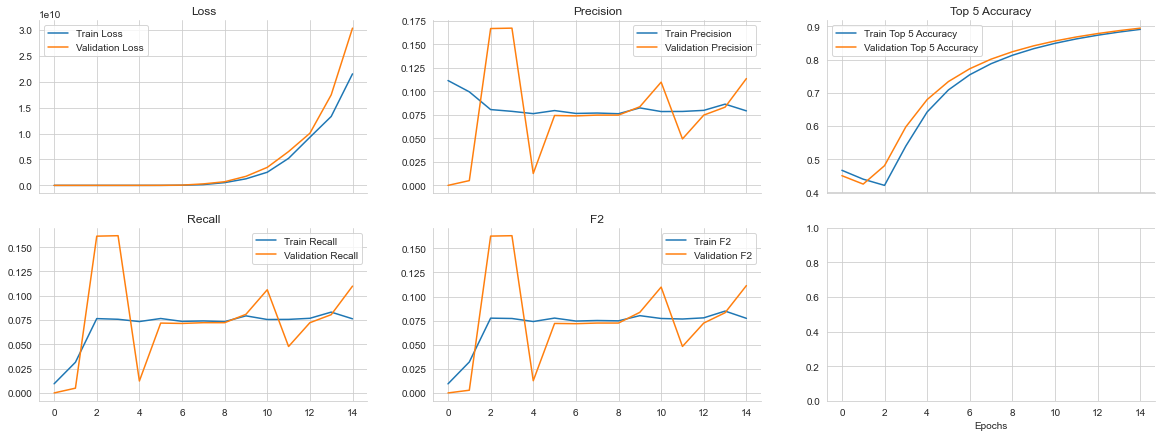

In [10]:
sns.set_style("whitegrid")
fig, axs = plt.subplots(2, 3, sharex='col', figsize=(20,7))


axs[0,0].plot(history.history['loss'], label='Train Loss')
axs[0,0].plot(history.history['val_loss'], label='Validation Loss')
axs[0,0].legend(loc='best')
axs[0,0].set_title('Loss')

axs[0,1].plot(history.history['precision'], label='Train Precision')
axs[0,1].plot(history.history['val_precision'], label='Validation Precision')
axs[0,1].legend(loc='best')
axs[0,1].set_title('Precision')

axs[1,0].plot(history.history['recall'], label='Train Recall')
axs[1,0].plot(history.history['val_recall'], label='Validation Recall')
axs[1,0].legend(loc='best')
axs[1,0].set_title('Recall')

axs[1,1].plot(history.history['f2_score'], label='Train F2')
axs[1,1].plot(history.history['val_f2_score'], label='Validation F2')
axs[1,1].legend(loc='best')
axs[1,1].set_title('F2')

axs[0,2].plot(history.history['top_k_categorical_accuracy'], label='Train Top 5 Accuracy')
axs[0,2].plot(history.history['val_top_k_categorical_accuracy'], label='Validation Top 5 Accuracy')
axs[0,2].legend(loc='best')
axs[0,2].set_title('Top 5 Accuracy')

plt.xlabel('Epochs')
sns.despine()
plt.show()